In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
import pickle
warnings.filterwarnings('ignore')

## Functions

In [9]:
def save_model(model):
    filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [10]:
def predict_evaluate(pred, true, graphName = 'Energy Usage Prediction', showplots=False):
    
    diff = [abs(prediction[i]-true[i]) for i in range(len(prediction))]
    
    resultingPlot = plt.figure(figsize=(25,10))
    plt.plot(true, color='red', label='Original Usage')
    plt.plot(prediction, color='blue', label='Predicted Usage')
    plt.plot(diff, color='green', label='Error')
    plt.title(graphName)
    plt.ylabel('kW')
    plt.legend()
    
    mape = mean_absolute_percentage_error(true, prediction)
    mae = mean_absolute_error(true, prediction)
    maxae = max(diff)[0]
    mse = mean_squared_error(true, prediction)
    
    if showplots:
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=64))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=24,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    loss_per_epoch = history.history['loss']
    
    if showplot:
        plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
        

In [12]:
directory = "../../datsets/LCL_Data_Transformed/"
allHouses = sorted(os.listdir(directory))

trainNumber = 10
testNumber = 1

testUsers = sample(allHouses, testNumber)
trainUsers = sample(allHouses, trainNumber)

featuresNames = ['use', 'hour', 'weekday', 'month']
targetName = ['use']
past_window = 24

model = define_model(past_window, len(featuresNames))

## Train generic model with multiple houses

In [13]:
for filename in trainUsers:
    print("Training with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        #print(df.isna().values.any())
        #print(df[df['use'].isna()])
        #continue
        
        features = df[featuresNames].values
        target = df[targetName].values
        
        #SCALE
        x_scaler = MinMaxScaler()
        x_train = x_scaler.fit_transform(features)

        y_scaler = MinMaxScaler()
        y_train = y_scaler.fit_transform(target)
        
        #Time series
        batch_size=64
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        
        train(model, train_generator)
                
#prediction = model.predict(x_test).reshape(-1, 1)
#prediction = y_scaler.inverse_transform(prediction)

Training with  MAC002735.csv
Training with  MAC002823.csv
Training with  MAC000390.csv
Training with  MAC002630.csv
Training with  MAC000027.csv
Training with  MAC002503.csv
Training with  MAC000077.csv
Training with  MAC002160.csv
Training with  MAC002348.csv
Training with  MAC000089.csv


## Test generic model for 1 house

Testing with  MAC003283.csv


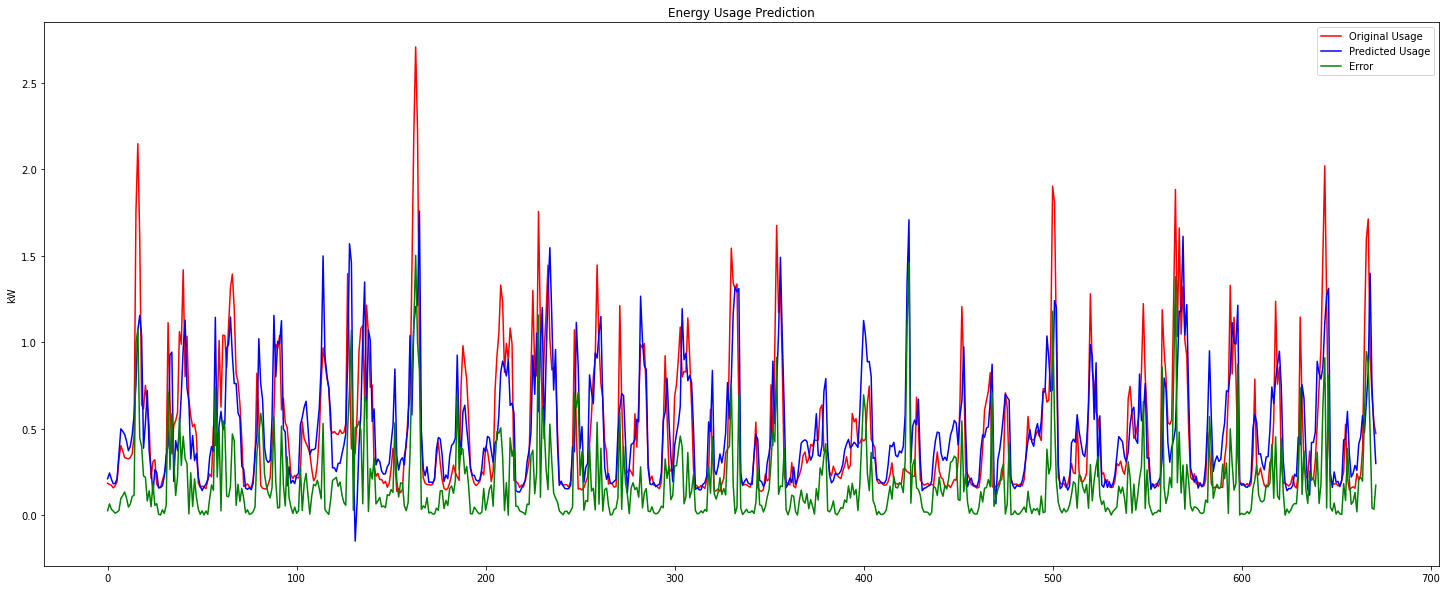

Mean Absolute Percentage Error:  0.4512915086047145
Mean Absolute Error:  0.18683257403249853
Max Absolute Error:  1.5012206826889036
Mean Squared Error:  0.08544261447506708


In [15]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values[-(24*30-past_window):]
    target = df[targetName].values[-(24*30-past_window):]

    #SCALE
    x_scaler = MinMaxScaler()
    x_test = x_scaler.fit_transform(features)

    y_scaler = MinMaxScaler()
    y_test = y_scaler.fit_transform(target)

    #Time series
    batch_size=64
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)

    prediction = model.predict(test_generator).reshape(-1, 1)

    prediction = y_scaler.inverse_transform(prediction)


    predict_evaluate(prediction, target[past_window:], showplots=True)

## Test specific model with same house

Testing with  MAC003283.csv


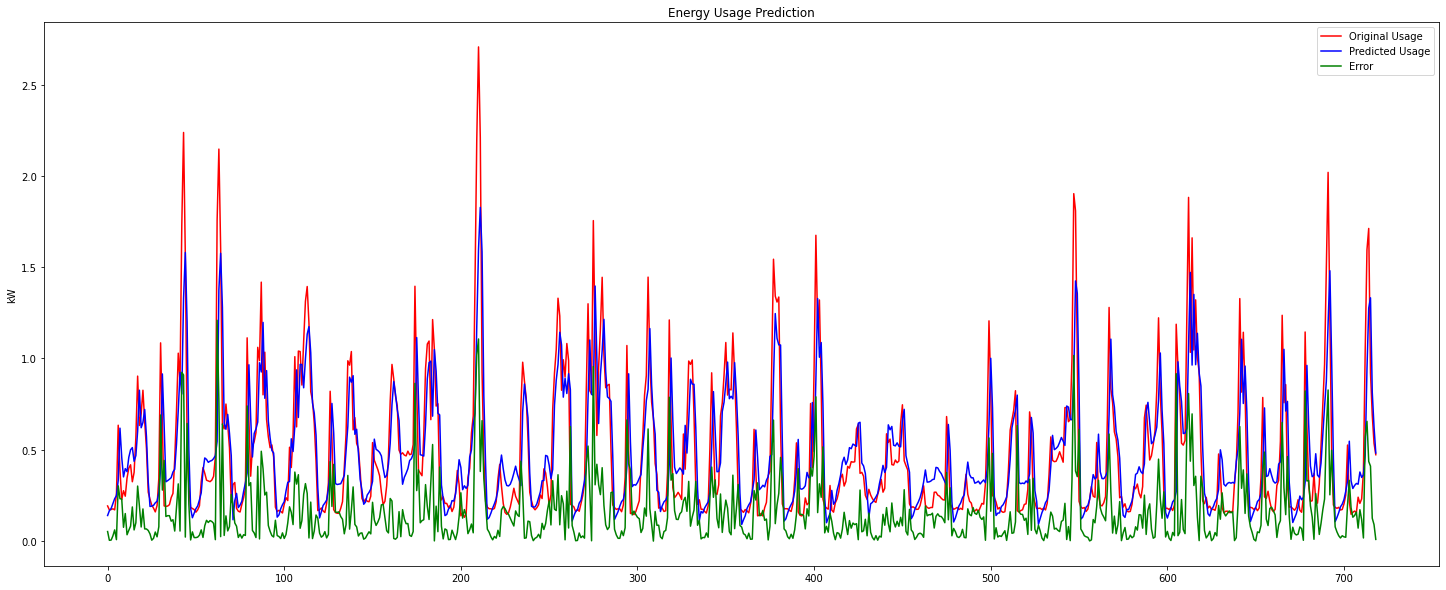

Mean Absolute Percentage Error:  0.39538955786498525
Mean Absolute Error:  0.1587403091828199
Max Absolute Error:  1.2090695910453797
Mean Squared Error:  0.05787360936473633


In [21]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')

    specific_model = define_model(past_window, len(featuresNames))
        
    features = df[featuresNames].values
    target = df[targetName].values.reshape(-1, 1)
    
    x_train, x_test, y_train, y_test = train_test_split(features,target, test_size=24*30, shuffle=False)


    #SCALE
    x_scaler = MinMaxScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)
    

    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train)

    #Time series
    batch_size=64
    train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)
    
    train(specific_model, train_generator)


    prediction = specific_model.predict(test_generator).reshape(-1, 1)
    prediction = y_scaler.inverse_transform(prediction)
    predict_evaluate(prediction, y_test[past_window:], showplots=True)

In [ ]:
for filename in testUsers:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values
    target = df[targetName].values
    
    #new dataframe step by step
    d = {key:[] for key in df.columns}
    userKnownDf = pd.DataFrame(data=d)
    
    for index, row in df.iterrows():
        